# Regression Discontinuity

## *Workshop 9*  [![Open In Colab](https://github.com/huanfachen/DSSS/blob/main/colab-badge.png?raw=1)](https://colab.research.google.com/github/huanfachen/DSSS/blob/main/Week_9/Practical_09_Regression_Discountinuity.ipynb)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

style.use("fivethirtyeight")


Last week, we set up a difference model and made causal claims about the effect of minimum wage laws on unemployment. We did this by treating Pennsylvania as a control group for New Jersey on the basis that they had similar trends in unemployment before the minimum wage law, and diverging trends after, and no other shock coincided with this policy. 

We could still poke some holes in that-- NJ seems to have fared worse than PA after the 2008 crisis; maybe more people work in finance in NJ. Indeed, Jersey City is across the water from Manhattan, America's financial centre. Bankers would be hard hit by a financial crisis, but are probably not that affected by minimum wage laws. Conversely, Pennsylvania is the 3rd largest coal-producing state in the U.S.-- coal miners are probably less affected by financial crises, but more likely to be earning minimum wage. As such, increasing the minimum wage in a place where most people are bankers probably has less of an effect on unemployment compared to an area where everyone is a coal miner. 

Running a state-level analysis is subject to this sort of selection bias, since by looking at state averages we're effectively comparing places like Jersey City to places like [Centralia](https://en.wikipedia.org/wiki/Centralia,_Pennsylvania), a coal-mining town in central Pennsylvania which saw its population decline from 1000 in 1980 to just five residents in 2020. So the next step in our analysis might be to try to compare apples to apples. There are a number of ways of doing this-- we could look at the unemployment rate by industry, for example. But what if we didn't want to rely on pre-trends, or if we didn't even have data prior to the treatment? This is often the case

To build a more valid counterfactual, we can drill even deeper to find even more similar comparison groups using a **Regression Discontinuity Design (RDD)** using county (rather than state) level data. 

> **[Regression Discontinuity Designs](https://www.princeton.edu/~davidlee/wp/RDDEconomics.pdf)** are a method of estimating treatment effects in a nonexperimental setting where treatment is determined by whether an observed “assignment” variable exceeds a known cutoff point. If the cutoff is exogenous to the treatment, observations in the vicinity of this cutoff are likely to be very similar, and assignment to the treatment or control group can be considered as good as random.

RDD models generally take the following form: 

$$\huge Y_{i} = \beta_0 + \beta_1 R_i + \beta_2 T_i + \varepsilon_{i}$$

$$\large T_i=    \begin{cases}
      1 & R_i>c\\
      0 & R_i<c\\
    \end{cases} $$

Where R is the "running variable", T is the treatment variable, and c is a cutoff in the running variable assigning observations to the "treatment" or "control" groups. 

In our case, the treatment is the minimum wage law passed in NJ in 2014. We want to be looking at the period after this to pick up on any changes in employment. The **assignment variable** in this case could be the distance of a county to the border between the two states, and the sharp cutoff would be the border itself. Counties on the border counties are probably much more similar to each other than other, farther away counties: this would exclude both Jersey City (in the far east of NJ) and Centralia (in the centre of PA). 

Indeed, several cities are divided by the border between these states including Philladelphia, the capital city of Pennsylvania: 

In [2]:
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles
Map(basemap=basemap_to_tiles(
    basemaps.Esri.WorldImagery),
  center=(39.95279958991338, -75.1341365382268),
  zoom=14)

Map(center=[39.95279958991338, -75.1341365382268], controls=(ZoomControl(options=['position', 'zoom_in_text', …

On the left side of the river is Philladelphia, PA, while on the right side is Camden, NJ. The code below uses the county shapefile we used before to isolate the counties in NJ and PA that are on the border.

Text(0.5, 1.0, 'Border Counties in New Jersey and Pennsylvania')

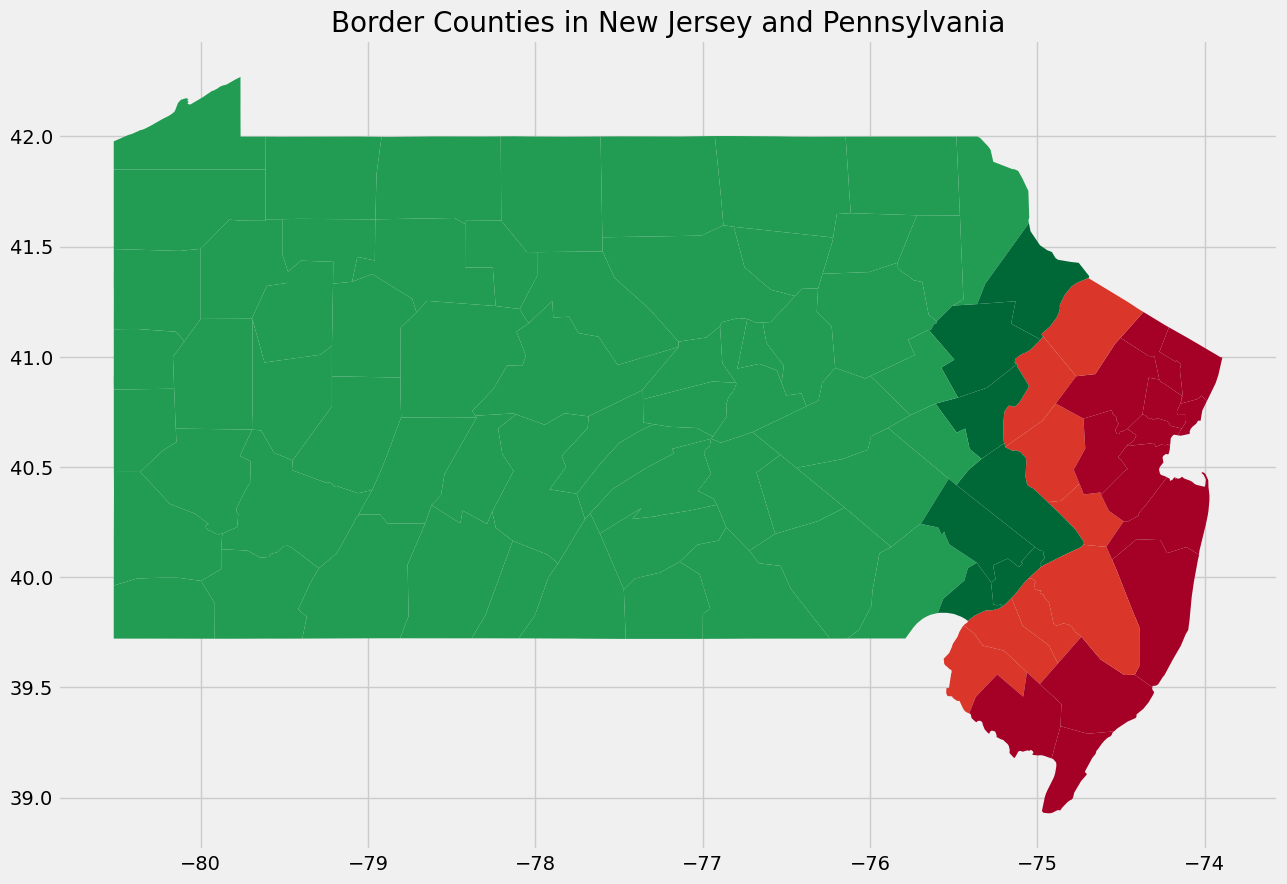

In [3]:
import geopandas as gpd

shp = gpd.read_file('https://raw.githubusercontent.com/huanfachen/DSSS/main/data/US_county/geojson-counties-fips.json') # read in the counties shapefile

subset=shp[shp['STATE'].isin(['34','42'])] # new jersey = 34, pennsylvania = 42, new york = 36
subset['neighbors']= '' # create a new column called neighbors, default at empty string

for index, row in subset.iterrows():  # iterate through each row in the counties shapefile
    buffered= row['geometry'].buffer(0.1) # create a buffer around the county so that it overlaps with its neighbors
    neighbors = list(set(subset[subset.geometry.overlaps(buffered)].STATE.tolist()).difference([row.STATE])) # check which counties overlap with the buffer, grab the state code, and remove the current county's state code
    subset.at[index, "neighbors"] = ", ".join(neighbors) # add the list of neighbors to the neighbors column

subset['border']=np.where(subset['neighbors']=='',0,1) # create a new column called border that is 1 if the county is on the border and 0 if it is not

subset['viscol']=subset['STATE'].astype(int)+subset['border'] # create a new column that combines the state code and the border column
subset.plot(column='viscol',legend=False, figsize=(20,10), cmap='RdYlGn') # plot the counties and color them by the border column
plt.title('Border Counties in New Jersey and Pennsylvania', fontsize=20) # add a title

We could now restrict our sample to only include counties within a set distance the border, and set up a regression discontinuity design in which: 

* unemployment is the dependent variable. 
* state (NJ/PA) is the treatment variable. 
* distance from the border is the running variable. 

This would probably give us a much better idea of the impact of the minimum wage law by discarding counties that are very far away from eachother and thus dissimilar. This example captures the basic intuition behind regression discontinuity, but we might worry that the minimum wage law isn't the only thing that changes as the discontinutiy (i.e., isn't the only thing that changes between NJ and PA). 

It is quite common to use distance as a running variable in RDD, and if you're interested in a review of the literature on spatial RDD models check out [this article](https://www.jstor.org/stable/24572845). 

To get a firm grasp of the intuition and mechanics behind RDD, we'll use a more straightforward example. 

## Is Alcohol Killing You?

A very relevant public policy question is what should be the minimal drinking age. Most countries, Brazil included, set it to be 18 year, but in the US (most states) it is currently 21. So, is it the case that the US is being overly prudent and that they should lower their minimal drinking age? Or is it the case that other countries should make their legal drinking age higher? 

One way to look at this question is from a [mortality rate perspective (Carpenter and Dobkin, 2009)](https://www.aeaweb.org/articles?id=10.1257/app.1.1.164). From the public policy standpoint, one could argue that we should lower the mortality rate as much as possible. If alcohol consumption increases the mortality rate by a lot, we should avoid lowering the minimum drinking age. This would be consistent with the objective of lowering deaths caused by alcohol consumption.

To estimate the impacts of alcohol on death, we could use the fact that legal drinking age imposes a discontinuity on nature. In the US, those just under 21 years don't drink (or drink much less) while those just older than 21 do drink. This means that the probability of drinking jumps at 21 years and that is something we can explore with an RDD.

To do so we can grab some mortality data aggregated by age. Each row is the average age of a group of people and the average mortality by all causes (`all`), by moving vehicle accident (`mva`) and by suicide (`suicide`). 

In [4]:
drinking = pd.read_csv("https://raw.githubusercontent.com/huanfachen/DSSS/main/data/drinking.csv")
drinking.head()[["agecell", "all", "mva", "suicide"]]

,agecell,all,mva,suicide
0,19.068493,92.825400,35.829327,11.203714
1,19.150684,95.100740,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315070,88.427760,32.278957,11.275010
4,19.397260,88.704940,32.650967,10.984314


Just to aid visibility (and for another important reason we will see later) we will centralize the running variable `agecell` at the threshold 21.

In [5]:
drinking["agecell"] -= 21

If we plot the multiple outcome variables (`all`, `mva`, `suicide`) with the runing variable on the x axis, we get some visual cue about some sort of jump in mortality as we cross the legal drinking age.

<Axes: xlabel='agecell', ylabel='suicide'>

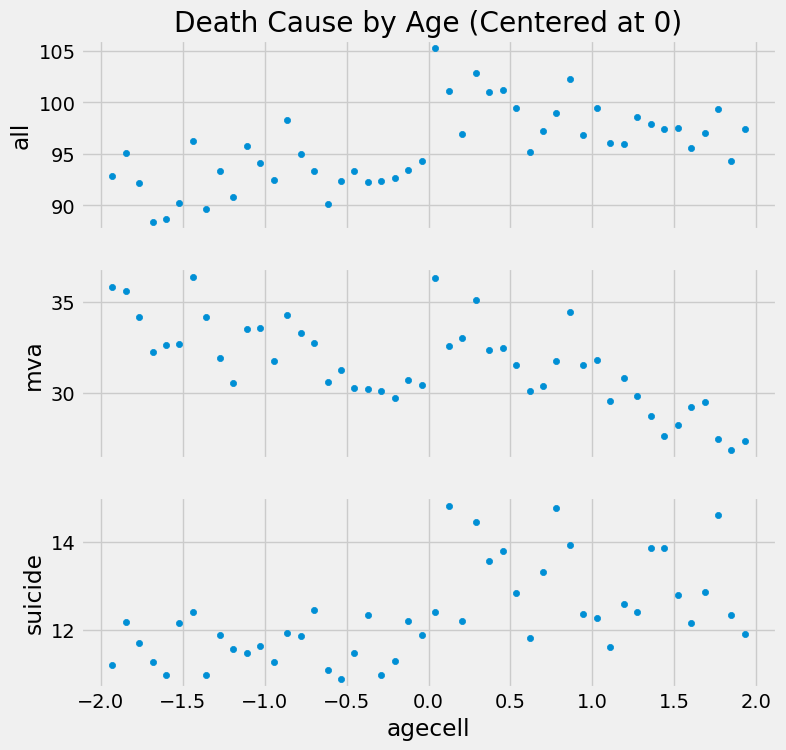

In [6]:
plt.figure(figsize=(8,8))
ax = plt.subplot(3,1,1)
drinking.plot.scatter(x="agecell", y="all", ax=ax)
plt.title("Death Cause by Age (Centered at 0)")

ax = plt.subplot(3,1,2, sharex=ax)
drinking.plot.scatter(x="agecell", y="mva", ax=ax)

ax = plt.subplot(3,1,3, sharex=ax)
drinking.plot.scatter(x="agecell", y="suicide", ax=ax)


There are some cues, but we need more than that. What exactly is the effect of drinking on mortality at the threshold? And what is the standard error on that estimate?

## RDD Estimation

The key assumption that RDD relies on is the smoothness of the potential outcome at the threshold. We can think of RDD as a local randomized trial. For those at the threshold, the treatment could have gone either way and, by chance, some people fell below the threshold, and some people fell above. In our example, at the same point in time, some people are just above 21 years and some people are just below 21. What determines this is if someone was born some days later or not, which is pretty random. For this reason, RDD provides a very compelling causal story. It is not the golden standard of RCT, but it is close. 

Now, to estimate the treatment effect at the threshold, all we need to do is estimate both of the limits in the formula above and compare them. The simplest way to do that is by running a linear regression


To make it work, we interact a dummy for being above the threshold with the running variable

$
y_i = \beta_0 + \beta_1 \mathcal{1}\{r_i>c\} + \beta_2 r_i + \beta_3 \mathcal{1}\{r_i>c\} r_i
$

where $r_i$ is the age value and $c$ is the age threshold (21 in this case study). $\mathcal{1}\{...\}$ is called an indicator function, which returns 1 when the statement is true and 0 otherwise.

Essentially, this is the same as fitting a linear regression above the threshold and another below it. The parameter $\beta_0$ is the intercept of the regression below the threshold and $\beta_0+\beta_1$ is the intercept for the regression above the threshold.

Here is where the trick of centering the running variable at the threshold comes into play. After this pre-processing step, the threshold becomes zero. This causes the intercept $\beta_0$ to be the predicted value at the threshold, for the regression below it. By the same reasoning, $\beta_0+\beta_1$ is the limit of the outcome from above. 

Here is what this looks like in code for the case where we want to estimate the effect of alcohol consumption on death by all causes at 21 years.

In [7]:
rdd_df = drinking.assign(threshold=(drinking["agecell"] > 0).astype(int))
model = smf.wls("all~ agecell * threshold ", rdd_df).fit() # this formula contains three variables: agecell, threshold, the interaction between agecell and threshold
print(model.summary())

                            WLS Regression Results                            
Dep. Variable:                    all   R-squared:                       0.668
Model:                            WLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     29.47
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           1.33e-10
Time:                        17:38:55   Log-Likelihood:                -105.64
No. Observations:                  48   AIC:                             219.3
Df Residuals:                      44   BIC:                             226.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            93.6184      0.93

This model is telling us that mortality increases by 7.6627 points with the consumption of alcohol. Another way of putting this is that alcohol increases the chance of death by all causes by 8% $(100*((7.6627+93.6184)/93.6184 - 1))$. Notice that this also gives us standard errors for our causal effect estimate. In this case, the effect is statistically significant, since the p-value is below 0.01. We can calculate the treatment effect programattically as follows:

In [8]:
ate_pct = 100*((model.params["threshold"] + model.params["Intercept"])/model.params["Intercept"] - 1)

print("Alcohol increases the chance of death by all causes by {}%".format(np.round(ate_pct,2)))

Alcohol increases the chance of death by all causes by 8.19%


**What if some variables have HIGH p values (>0.05) and are not statistically significant?**

It's not a good idea to remove these variables with high p values and then re-run the linear model. This is because a RDD model requires these necessary variables; if one or more variables are removed, it is no longer a valid RDD model.

Therefore, we are not going to remove any variable or create a new model. Instead, we can interpret the coefficients and p values of each variable. For example, you can say the *agecell* variable is not statistically significant, indicating that the age variable is unlikely to be associated with the all-cause causality.


If we want to verify this model visually, we can show the predicted values on the data that we have. You can see that it is as though we had 2 regression models: one for those above the threshold and one for below it.

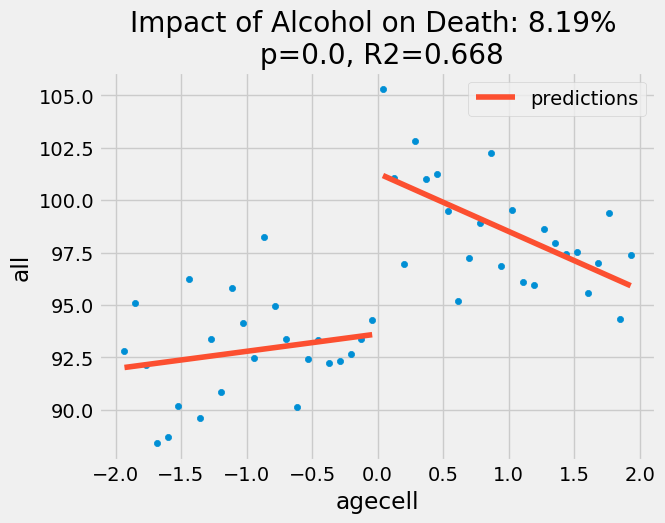

In [9]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}% \n p={np.round(model.pvalues['threshold'], 3)}, R2={np.round(model.rsquared, 3)}")
plt.show()

### Exercise 1

You'll remember from the lecture slides that the model we've fit above is a linear, different slopes design. Try fitting the following models:

1. Linear, Same Slopes 
2. Quadratic, Same Slopes 
3. Quadratic, Different Slopes

Pay attention to the treatment effect. Is it consistent across models? Which model has the highest treatment effect? Which model fits the best?

RDD with linear, same slopes design

$
y_i = \beta_0 + \beta_1 \mathcal{1}\{r_i>c\} + \beta_2 r_i
$

In [10]:
# RDD with linear, same slopes design
model_linear_same_slope = smf.wls("all~ agecell + threshold ", rdd_df).fit() # this formula contains three variables: agecell, threshold, the interaction between agecell and threshold
print(model_linear_same_slope.summary())

                            WLS Regression Results                            
Dep. Variable:                    all   R-squared:                       0.595
Model:                            WLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     32.99
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           1.51e-09
Time:                        17:38:55   Log-Likelihood:                -110.41
No. Observations:                  48   AIC:                             226.8
Df Residuals:                      45   BIC:                             232.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     91.8414      0.805    114.083      0.0

RDD with quadratic, same slopes design

$
y_i = \beta_0 + \beta_1 \mathcal{1}\{r_i>c\} + \beta_2 r_i + \beta_3 {r_i}^2
$

In [11]:
# RDD with quadratic, same slopes design
model_quadratic_same_slope = smf.wls("all~ agecell + threshold + np.power(agecell, 2)", rdd_df).fit() # this formula contains three variables: agecell, threshold, the interaction between agecell and threshold
print(model_quadratic_same_slope.summary())

                            WLS Regression Results                            
Dep. Variable:                    all   R-squared:                       0.657
Model:                            WLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     28.12
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           2.61e-10
Time:                        17:38:56   Log-Likelihood:                -106.38
No. Observations:                  48   AIC:                             220.8
Df Residuals:                      44   BIC:                             228.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               92.9027 

RDD with quadratic, different slopes design

$
y_i = \beta_0 + \beta_1 \mathcal{1}\{r_i>c\} + \beta_2 {r_i} + \beta_3 {r_i}^2 + \beta_4 \mathcal{1}\{r_i>c\} r_i + \beta_5 \mathcal{1}\{r_i>c\} {r_i}^2 
$

In [12]:
# RDD with quadratic, different slopes design
model_quadratic_different_slope = smf.wls("all~ agecell + threshold + np.power(agecell, 2) + threshold*agecell + threshold*np.power(agecell, 2)", rdd_df).fit() # this formula contains three variables: agecell, threshold, the interaction between agecell and threshold
print(model_quadratic_different_slope.summary())

                            WLS Regression Results                            
Dep. Variable:                    all   R-squared:                       0.682
Model:                            WLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     18.02
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           1.62e-09
Time:                        17:38:56   Log-Likelihood:                -104.57
No. Observations:                  48   AIC:                             221.1
Df Residuals:                      42   BIC:                             232.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

By comparing the R square and adjusted R square of the above four models, we find out that the model with the quadratic, different slope design fits the best.

### Exercise 2

Now, assess the impact of drinking on motor vehicle accidents (`mva`) and suicide (`suicide`), and compare them to the impact on all-cause mortality (`all`). In each case, run a RDD model.

Which cause of death does drinking appear to have the strongest effect on? Which model specification (e.g. linear, same slope) fits the best?

### Kernel Weighting

Regression Discontinuity relies heavily on the extrapolations properties of linear regression. Since we are looking at the values at the beginning and end of 2 regression lines, we better get those limits right. What can happen is that regression might focus too much on fitting the other data points at the cost of a poor fit at the threshold. If this happens, we might get the wrong measure of the treatment effect.

One way to solve this is to give higher weights for the points that are closer to the threshold. There are many ways to do this, but a popular one is to reweight the samples with the **triangular kernel**

$
K(R, c, h) = \mathcal{1}\{|R-c| \leq h\} * \bigg(1-\frac{|R-c|}{h}\bigg)
$

The first part of this kernel is an indicator function to whether we are close to the threshold. How close? This is determined by a bandwidth parameter $h$. The second part of this kernel is a weighting function. As we move away from the threshold, the weights get smaller and smaller. These weights are divided by the bandwidth. If the bandwidth is large, the weights get smaller at a slower rate. If the bandwidth is small, the weights quickly go to zero. 

To make it easier to understand, here is what the weights look like for this kernel applied to our problem. I've set the bandwidth to be 1 here, meaning we will only consider data from people that are no older than 22 years and no younger than 20 years.

In [13]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

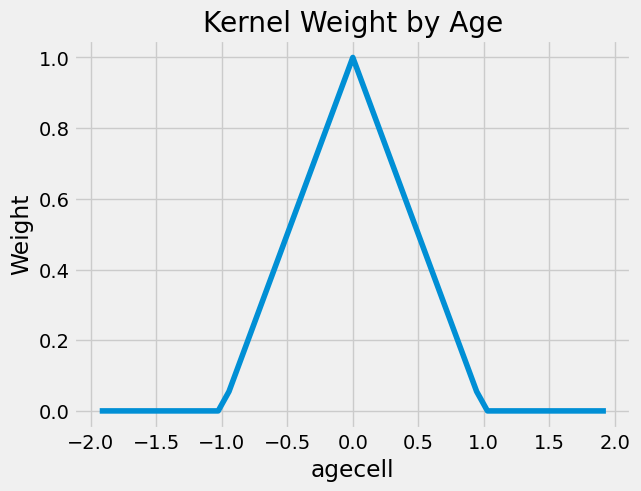

In [14]:
plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1))
plt.xlabel("agecell")
plt.ylabel("Weight")
plt.title("Kernel Weight by Age");

If we apply these weights to our original problem, the impact of alcohol gets bigger, at least for all causes. It jumps from 7.6627 to 9.7004. The result remains very significant. Also, notice that I'm using `wls` instead of `ols`

In [15]:
model = smf.wls("all~agecell*threshold", rdd_df,
                weights=kernel(drinking["agecell"], c=0, h=1)).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.2002,0.731,127.429,0.000,91.726,94.674
agecell,0.4109,1.789,0.230,0.819,-3.196,4.017
threshold,9.7004,1.034,9.378,0.000,7.616,11.785
agecell:threshold,-7.1759,2.531,-2.835,0.007,-12.276,-2.075


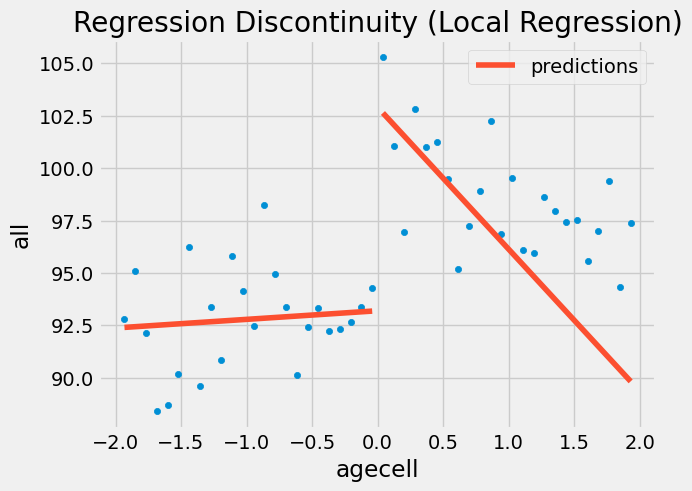

In [16]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity (Local Regression)");

And here is what it looks like for the other causes of death. Notice how the regression on the right is more negatively sloped since it disconsiders the right most points. 

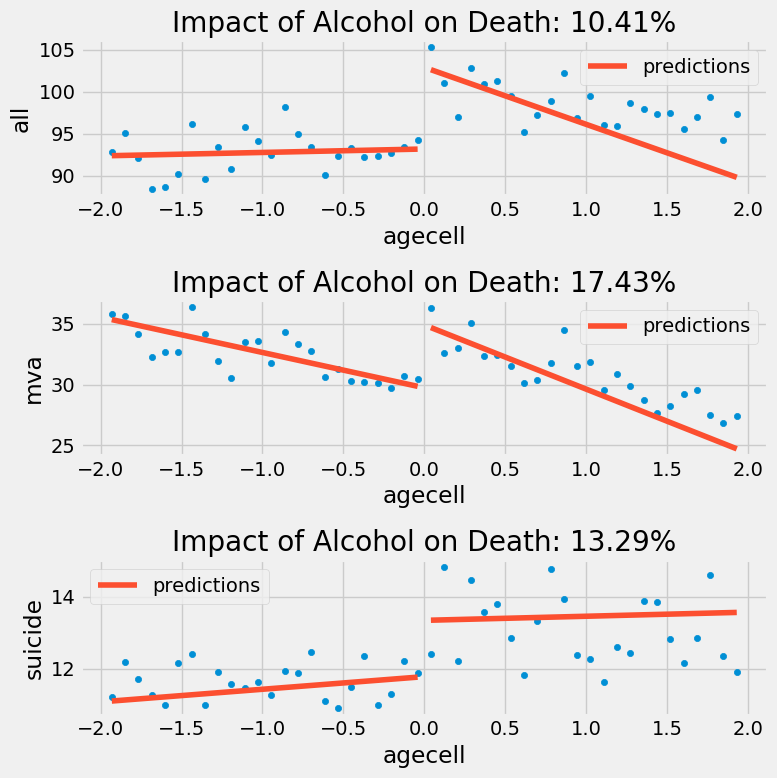

In [17]:
plt.figure(figsize=(8,8))
weights = kernel(drinking["agecell"], c=0, h=1)

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df, weights=weights).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Impact of Alcohol on Death: {np.round(ate_pct, 2)}%")

plt.tight_layout()

With the exception of suicide, it looks like adding the kernel weight made the negative impact on alcohol bigger. Once again, if we want to minimize the death rate, we should NOT recommend lowering the legal drinking age, since there is a clear impact of alcohol on the death rates.

This simple case covers what happens when regression discontinuity design works perfectly. Next, we will see some diagnostics that we should run in order to check how much we can trust RDD and talk about a topic that is very dear to our heart: the effect of education on earnings.

## Sheepskin Effect and Fuzzy RDD

When it comes to the effect of education on earnings, there are two major views in economics. The first one is the widely known argument that education increases human capital, increasing productivity and thus, earnings. In this view, education actually changes you for the better. Another view is that education is simply a signaling mechanism. It just puts you through all these hard tests and academic tasks. If you can make it, it signals to the market that you are a good employee. In this way, education doesn't make you more productive. It only tells the market how productive you have always been. What matters here is the diploma. If you have it, you will be paid more. We refer to this as the **sheepskin effect**, since diplomas were printed in sheepskin in the past.

To test this hypothesis, [Clark and Martorell](https://faculty.smu.edu/millimet/classes/eco7321/papers/clark%20martorell%202014.pdf) used regression discontinuity to measure the effect of graduating 12th grade on earnings. In order to do that, they had to think about some running variable where students that fall above it graduate and those who fall below it, don't. They found such data in the Texas education system.

In order to graduate in Texas, one has to pass an exam. Testing starts at 10th grade and students can do it multiple times, but eventually, they face a last chance exam at the end of 12th grade. The idea was to get data from students who took those last chance exams and compare those that had barely failed it to those that barely passed it. These students will have very similar human capital, but different signaling credentials. Namely, those that barely passed it, will receive a diploma. 

In [18]:
sheepskin = pd.read_csv("https://raw.githubusercontent.com/huanfachen/DSSS/main/data/sheepskin.csv")[["avgearnings", "minscore", "receivehsd", "n"]]
sheepskin.head()

,avgearnings,minscore,receivehsd,n
0,11845.086,-30.0,0.416667,12
1,9205.679,-29.0,0.387097,31
2,8407.745,-28.0,0.318182,44
3,11114.087,-27.0,0.377778,45
4,10814.624,-26.0,0.306667,75


Once again, this data is grouped by the running variable. It contains not only the running variable (minscore, already centered at zero) and the outcome (avgearnings), but it also has the probability of receiving a diploma in that score cell and the size of the call (n). So, for example, out of the 12 students in the cell -30 below the score threshold, only 5 were able to get the diploma (12 * 0,416). 

This means that there is some slippage in the treatment assignment. Some students that are below the passing threshold managed to get the diploma anyway. Here, the regression discontinuity is **fuzzy**, rather than sharp. Notice how the probability of getting the diploma doesn't jump from zero to one at the threshold. But it does jump from something like 50% to 90%.

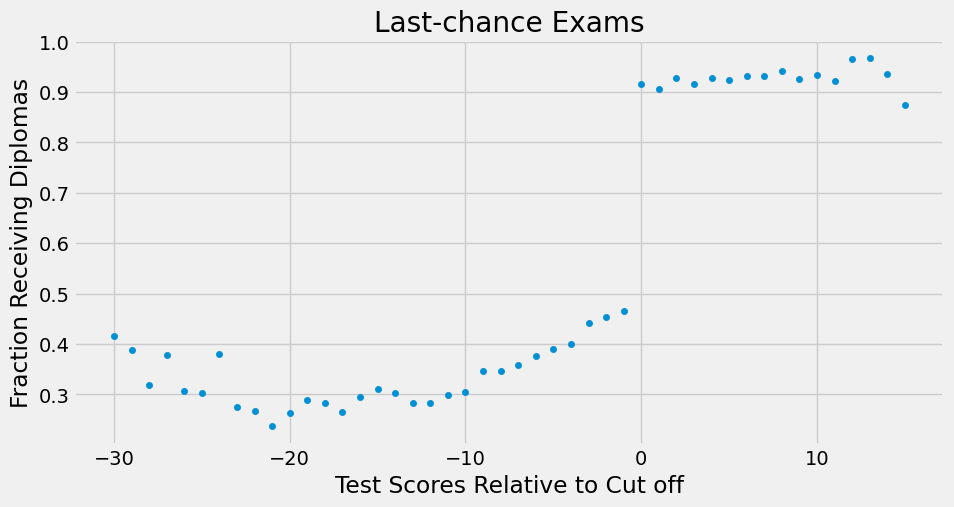

In [19]:
sheepskin.plot.scatter(x="minscore", y="receivehsd", figsize=(10,5))
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Fraction Receiving Diplomas")
plt.title("Last-chance Exams");

We can think of fuzzy RD as a sort of non compliance. Passing the threshold should make everyone receive the diploma, but some students, the never takers, don’t get it. Likewise, being below the threshold should prevent you from getting a diploma, but some students, the always takers, manage to get it anyway. 

Just like when we have the potential outcome, we have the potential treatment status in this situation. $T_1$ is the treatment everyone would have received had they been above the threshold. $T_0$ is the treatment everyone would have received had they been below the threshold. As you've might have noticed, we can think of the **threshold as an Instrumental Variable**. Just as in IV, if we naively estimate the treatment effect, it will be biased towards zero. 

![img](https://matheusfacure.github.io/python-causality-handbook/_images/rdd.png)

The probability of treatment being less than one, even above the threshold, makes the outcome we observe less than the true potential outcome $Y_1$. By the same token, the outcome we observe below the threshold is higher than the true potential outcome $Y_0$. This makes it look like the treatment effect at the threshold is smaller than it actually is and we will have to use IV techniques to correct for that.

But first, let's talk about a sanity check we need to run to make sure we can trust our RDD estimates.

### The McCrary Test

One thing that could break our RDD argument is if people can manipulate where they stand at the threshold. In the sheepskin example this could happen if students just below the threshold found a way around the system to increase their test score by just a bit. Another example is when you need to be below a certain income level to get a government benefit. Some families might lower their income on purpose, just to be just eligible for the program.

In these sorts of situations, we tend to see a phenomenon called bunching on the density of the running variable. This means that we will have a lot of entities just above or just below the threshold. To check for that, we can plot the density function of the running variable and see if there are any spikes around the threshold. For our case, the density is given by the `n` column in our data.

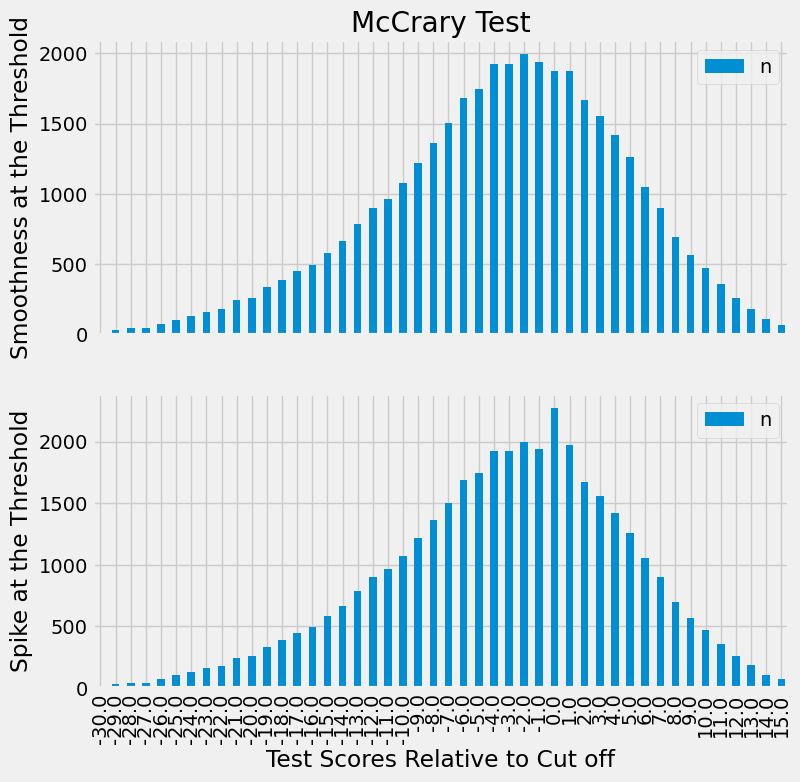

In [20]:
plt.figure(figsize=(8,8))

ax = plt.subplot(2,1,1)
sheepskin.plot.bar(x="minscore", y="n", ax=ax)
plt.title("McCrary Test")
plt.ylabel("Smoothness at the Threshold")

ax = plt.subplot(2,1,2, sharex=ax)
sheepskin.replace({1877:1977, 1874:2277}).plot.bar(x="minscore", y="n", ax=ax)
plt.xlabel("Test Scores Relative to Cut off")
plt.ylabel("Spike at the Threshold");

The first plot shows how our data density looks like. As we can see, there are no spikes around the threshold, meaning there is no bunching. Students are not manipulating where they fall on the threshold. Just for illustrative purposes, the second plot shows what bunching would look like if students could manipulate where they fall on the threshold. We would see a spike in the density for the cells just above the threshold, since many students would be on that cell, barely passing the exam. 

Getting this out of the way, we can go back to estimate the sheepskin effect. As I've said before, the numerator of the Wald estimator can be estimated just like we did in the Sharp RD. Here, we will use as weight the kernel with a bandwidth of 15. Since we also have the cell size, we will multiply the kernel by the sample size to get a final weight for the cell. 

In [21]:
sheepsking_rdd = sheepskin.assign(threshold=(sheepskin["minscore"]>0).astype(int))
model = smf.wls("avgearnings~minscore*threshold",
                sheepsking_rdd,
                weights=kernel(sheepsking_rdd["minscore"], c=0, h=15)*sheepsking_rdd["n"]).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.399e+04,83.678,167.181,0.000,1.38e+04,1.42e+04
minscore,181.6636,16.389,11.084,0.000,148.588,214.739
threshold,-97.7571,145.723,-0.671,0.506,-391.839,196.325
minscore:threshold,18.1955,30.311,0.600,0.552,-42.975,79.366


This is telling us that the effect of a diploma is -97.7571, but this is not statistically significant (P-value of 0.5). If we plot these results, we get a very continuous line at the threshold. More educated people indeed make more money, but there isn't a jump at the point where they receive the 12th grade diploma. This is an argument in favor of the view that says that education increases earnings by making people more productive, rather than being just a signal to the marker. In other words, there is no sheepskin effect. 

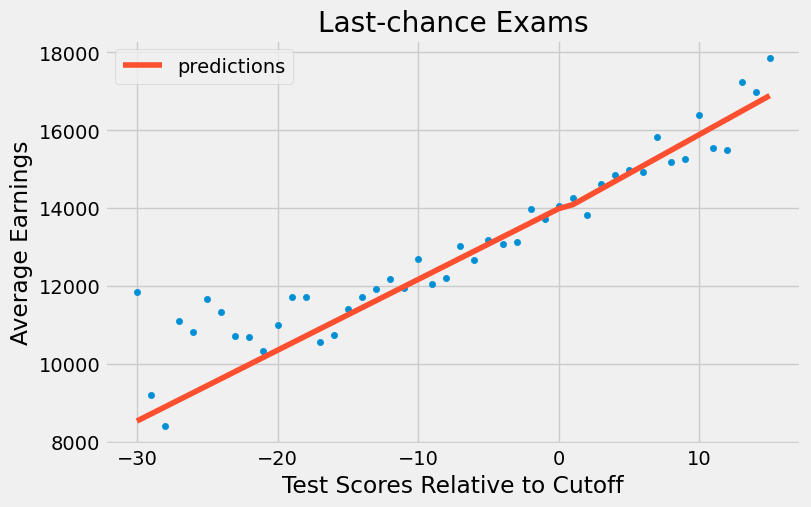

In [22]:
ax = sheepskin.plot.scatter(x="minscore", y="avgearnings", color="C0")
sheepskin.assign(predictions=model.fittedvalues).plot(x="minscore", y="predictions", ax=ax, color="C1", figsize=(8,5))
plt.xlabel("Test Scores Relative to Cutoff")
plt.ylabel("Average Earnings")
plt.title("Last-chance Exams");

However, as we know from the way non compliance bias works, this result is biased towards zero. To correct for that, we need to scale it by the first stage and get the Wald estimator. Unfortunately, there isn't a good Python implementation for this, so we will have to do it manually and use bootstrap to get the standard errors.

The code below runs the numerator of the Wald estimator just like we did before and also constructs the denominator by replacing the target variable with the treatment variable `receivehsd`. The final step just divides the numerator by the denominator. 

In [23]:
def wald_rdd(data):
    weights=kernel(data["minscore"], c=0, h=15)*data["n"]
    denominator = smf.wls("receivehsd~minscore*threshold", data, weights=weights).fit()
    numerator = smf.wls("avgearnings~minscore*threshold", data, weights=weights).fit()
    return numerator.params["threshold"]/denominator.params["threshold"]

In [24]:
from joblib import Parallel, delayed 

np.random.seed(45)
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(wald_rdd)(sheepsking_rdd.sample(frac=1, replace=True))
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

With the bootstrap samples, we can plot the distribution of ATEs and see where the 95% confidence interval is.

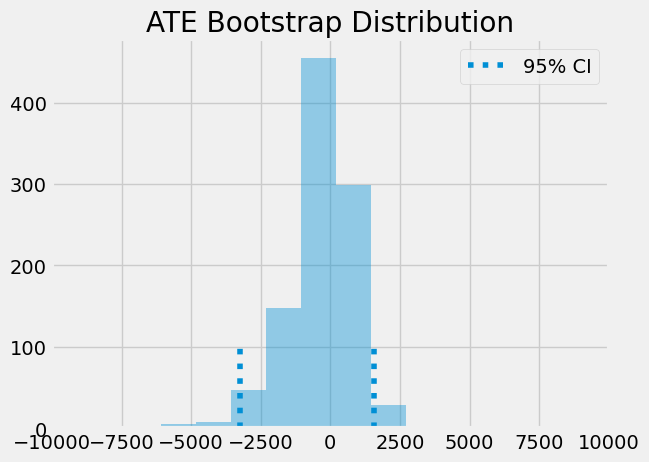

In [25]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 100, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 100, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.xlim([-10000, 10000])
plt.legend();

As you can see, even when we scale the effect by the first stage, it is still not statistically different from zero. This means that education doesn't increase earnings by a simple sheepskin effect, but rather by increasing one's productivity.

## Key Ideas

We learned how to take advantage of artificial discontinuities to estimate causal effects. The idea is that we will have some artificial threshold that makes the probability of treatment jump. One example that we saw was how age makes the probability of drinking jump at 21 years. We could use that to estimate the impact of drinking on mortality rate. We use the fact that very close to the threshold, we have something close to a randomized trial. Entities very close to the threshold could have gone either way and what determines where they've landed is essentially random. With this, we can compare those just above and just below to get the treatment effect. We saw how we could do that with weighted linear regression using a kernel and how this even gave us, for free, standard errors for our ATE.

Then, we look at what would happen in the fuzzy RD design, where we have non compliance. We saw how we could approach the situation much like we did with IV.


## References

This workshop is a modification of Chapter 16 of the handbook [Causal Inference for the Brave and True](https://github.com/matheusfacure/python-causality-handbook).

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Other important reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)


## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).